In [1]:
from pycuda.autoinit import context
import pycuda.driver as drv
from pycuda import cumath
from pycuda import gpuarray
import scikits.cuda.fft as cu_fft

In [2]:
from pypic import PyPIC_GPU as PIC
from meshing import RectMesh3D
from poisson_solver import FFT_solver as FFT
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import e

PyKLU not found


In [3]:
# define mesh, poissonsolver and PIC
mesh = RectMesh3D(0., 0., 0., 0.01, 0.01, 0.01, 32, 32, 32, mathlib=cumath)
poissonsolver = FFT.GPU_FFT_OpenBoundary(mesh, 0)
pic = PIC(mesh, poissonsolver, context=context)


(64, 64, 64)


In [4]:
# generate particles inside mesh
np.random.seed(0)
mesh_center_x = mesh.x0 + 0.5*mesh.nx*mesh.dx
mesh_center_y = mesh.y0 + 0.5*mesh.ny*mesh.dy
mesh_center_z = mesh.z0 + 0.5*mesh.nz*mesh.dz
N = 1024
xx = np.random.normal(mesh_center_x, 2*mesh.dx, N)
yy = np.random.normal(mesh_center_y, 2*mesh.dy, N)
zz = np.random.normal(mesh_center_z, 2*mesh.dz, N)
assert((xx > mesh.x0).all() and (xx < mesh.x0 + mesh.nx*mesh.dx).all())
assert((yy > mesh.y0).all() and (yy < mesh.y0 + mesh.ny*mesh.dy).all())
assert((zz > mesh.z0).all() and (zz < mesh.z0 + mesh.nz*mesh.dz).all())
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)

In [5]:
nx, ny, nz = 3, 4, 5
d_src = gpuarray.zeros((nz, ny, nx), dtype=np.float64)
d_dst = gpuarray.zeros((5,5,5), dtype=np.float64) + 1
cpy = drv.Memcpy3D()
cpy.set_src_device(d_src.ptr)
cpy.width_in_bytes = d_src.strides[2]*2 # how many bytes per row to copy
cpy.height = 3 # number of rows to copy
cpy.depth  = 5
cpy.src_pitch = d_src.strides[1] #size of a row in bytes at src
cpy.dst_pitch = d_dst.strides[1] #size of a row in bytes at dst
cpy.set_dst_device(d_dst.ptr)
cpy.src_height = ny
cpy.dst_height = 5
cpy()
a = d_dst.get()
print(a)
print d_dst.strides

[[[ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]]

 [[ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]]

 [[ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]]

 [[ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]]

 [[ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 0.  0.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]
  [ 1.  1.  1.  1.  1.]]]
(200, 40, 8)


In [6]:
def test_solver(new_solver, xx, yy, zz, charge=e, x_probe=None, y_probe=None, z_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    if z_probe == None:
        z_probe = zz
    mesh_charges = new_solver.particles_to_mesh(xx, yy, zz, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(mesh_charges)
#     mesh_e_fields = new_solver.get_electric_fields(phi)
#     efx = mesh_e_fields[0]
#     efy = mesh_e_fields[1]
#     efz = mesh_e_fields[2]
#     #for i, field in enumerate(mesh_e_fields):
#         #mesh_e_fields[i] = field.flatten()
#     mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe, z_probe])
#     fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
#     Ex = fields[0]
#     Ey = fields[1]
#     Ez = fields[2]
#     return rho, phi, efx, efy, efz, Ex, Ey, Ez
    return rho, phi

# rho, phi, efx, efy, efz, Ex, Ey, Ez = test_solver(pic, xx, yy, zz)
rho, phi = test_solver(pic, xx, yy, zz)



(32, 32, 32)


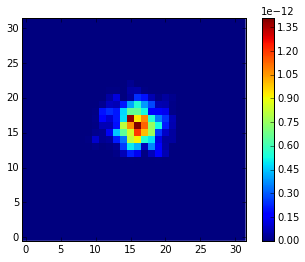

(32, 32, 32)


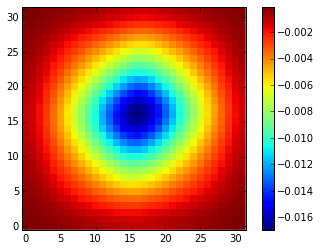

In [7]:
%matplotlib inline

print rho.get().shape
plt.imshow(rho.get()[mesh.nz//2], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

print phi.get().shape
plt.imshow(phi.get()[mesh.nz//2], origin='lower', interpolation='none')
plt.colorbar()
plt.show()

# print efx.get().shape
# plt.imshow(efx.get()[mesh.nz//2], origin='lower')
# plt.show()

# print efy.get().shape
# plt.imshow(efy.get()[mesh.nz//2], origin='lower')
# plt.show()


In [8]:
xx = np.zeros((10,20,30))
x = gpuarray.zeros(xx.shape, dtype=np.float64) + 1
y = gpuarray.zeros_like(x) + 1
plan = cu_fft.Plan(x.shape, np.float64, np.complex128)
cu_fft.fft(x,y,plan)
print(y.get())

[[[ 6000.     0.     0. ...,    -0.     0.    -0.]
  [    0.     0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,    -0.     0.    -0.]
  ..., 
  [    0.     0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,    -0.     0.    -0.]]

 [[    0.    -0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,     0.     0.    -0.]
  ..., 
  [    0.    -0.     0. ...,    -0.     0.    -0.]
  [    0.    -0.     0. ...,     0.     0.    -0.]
  [    0.    -0.     0. ...,     0.     0.     0.]]

 [[    0.    -0.     0. ...,     0.     0.     0.]
  [    0.     0.     0. ...,     0.     0.     0.]
  [    0.     0.     0. ...,     0.     0.     0.]
  ..., 
  [    0.     0.     0. ...,     0.     0.     0.]
  [    0.     0.     0. ...,     0.     0.     0.]
  [    0.     0.     0. ...,     0.     0.     0.]]

 ..., 
 [[    0.     0.     0. ...,     0.     0.   

In [9]:
def fft3(array_3d):
    # 1. all rows: fft
    # 2. all cols: fft
    # 3. all ... : fft
    nz, ny, nx = array_3d.shape
    plan_f_x = cu_fft.Plan(nx, in_dtype = np.float64, out_dtype=np.complex128,
                           batch=nx*ny )